In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/test.zip'),
 PosixPath('data/carvana/train-512'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks-1024'),
 PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/train_masks.csv.zip'),
 PosixPath('data/carvana/train_masks-512'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/metadata.csv.zip'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data/carvana/sample_submission.csv.zip'),
 PosixPath('data/carvana/test_hq.zip'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_hq.zip'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train.zip'),
 Po

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/5bc30efeb7bf_11.jpg'),
 PosixPath('data/carvana/train/e114fcbb9723_13.jpg'),
 PosixPath('data/carvana/train/e2230d0ceb02_02.jpg'),
 PosixPath('data/carvana/train/695f39dfac16_14.jpg'),
 PosixPath('data/carvana/train/3d7a1030deeb_02.jpg')]

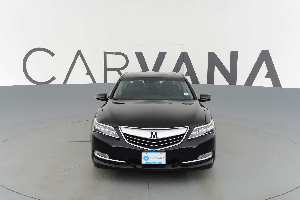

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/9274d0b3caa8_08_mask.gif'),
 PosixPath('data/carvana/train_masks/e114fcbb9723_08_mask.gif'),
 PosixPath('data/carvana/train_masks/5bcde75955bb_08_mask.gif'),
 PosixPath('data/carvana/train_masks/3cb21125f126_08_mask.gif'),
 PosixPath('data/carvana/train_masks/08a646be6b30_07_mask.gif')]

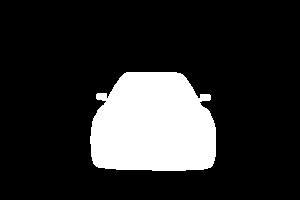

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

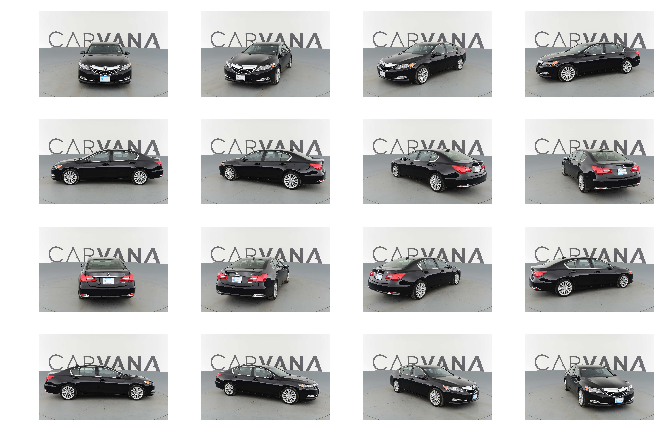

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [15]:
convert = False

In [16]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [17]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [18]:
if convert:
    files = list((PATH/'train_masks').iterdir())
    with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [19]:
def resize_mask(m):
    fn, sz = m
    Image.open(fn).resize((sz,sz)).save((fn.parent.parent)/f'train_masks-{sz}'/fn.name)

def get_masks(sz):
    return list((m, sz) for m in (PATH/'train_masks_png').iterdir())

def resize_img(i):
    fn, sz = i
    Image.open(fn).resize((sz,sz)).save((fn.parent.parent)/f'train-{sz}'/fn.name)

def get_images(sz):
    return list((i, sz) for i in (PATH/'train').iterdir())
    
if convert:
    for s in [128, 512, 1024]:
        masks = get_masks(s)
        (PATH/f'train_masks-{s}').mkdir(exist_ok=True)
        with ThreadPoolExecutor(8) as e: e.map(resize_mask, masks)

        images = get_images(s)
        (PATH/f'train-{s}').mkdir(exist_ok=True)
        with ThreadPoolExecutor(8) as e: e.map(resize_img, images)

## Show Cars with Masks

In [20]:
def show_cars_masks(sz, rows, cols, figsize):
    ims = [open_image(PATH/f'train-{sz}/{CAR_ID}_{i+1:02d}.jpg') for i in range(rows*cols)]
    im_masks = [open_image(PATH/f'train_masks-{sz}/{CAR_ID}_{i+1:02d}_mask.png') for i in range(rows*cols)]
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat):
        ax = show_img(ims[i], ax=ax)
        show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
    plt.tight_layout(pad=0.1)

In [21]:
def show_cars_mask_dl(md, rows, cols):
    denorm = md.trn_ds.denorm
    x,y = map(denorm, next(iter(md.aug_dl)))
    fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
    for i,ax in enumerate(axes.flat):
        ax=show_img(x[i], ax=ax)
        show_img(y[i][...,0], ax=ax, alpha=0.5)
    plt.tight_layout(pad=0.1)

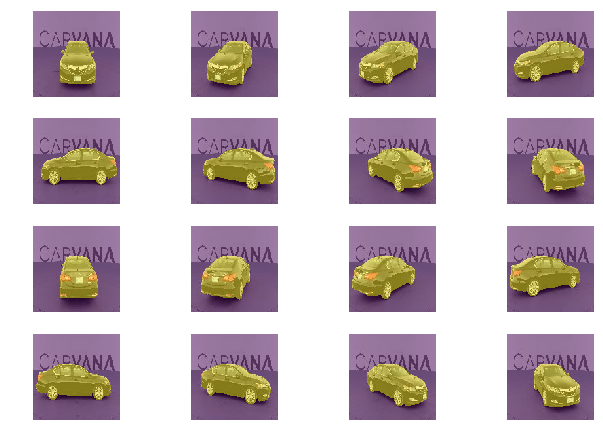

In [22]:
show_cars_masks(128, 4, 4, (9,6))

## Model

In [23]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [24]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [25]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[:,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[:,0], 0.5)

def dice(pred, targ):
    m1 = (pred[:,0]>0).float()
    m2 = targ[:,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [26]:
def get_model(sz, bs, num_workers, transf):
    x_names = np.array([Path(f'train-{sz}')/o for o in masks_csv['img']])
    y_names = np.array([Path(f'train_masks-{sz}')/f'{o[:-4]}_mask.png' for o in masks_csv['img']])
    val_idxs = list(range(len(x_names)//16//5*16))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    
    aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
                RandomFlip(tfm_y=TfmType.PIXEL),
                RandomLighting(0.05, 0.05)]
    
    tfms = tfms_from_model(transf, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=num_workers, classes=None)
    
    simple_up = nn.Sequential(
        nn.ReLU(),
        StdUpsample(512,256),
        StdUpsample(256,256),
        StdUpsample(256,256),
        StdUpsample(256,256),
        nn.ConvTranspose2d(256, 1, 2, stride=2),)
    
    models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=mask_loss
    learn.metrics=[mask_acc, dice]
    
    return learn, md

# Resnet34

In [27]:
transf = resnet34

## 128x128

In [92]:
learn, md = get_model(128, 64, 8, transf)

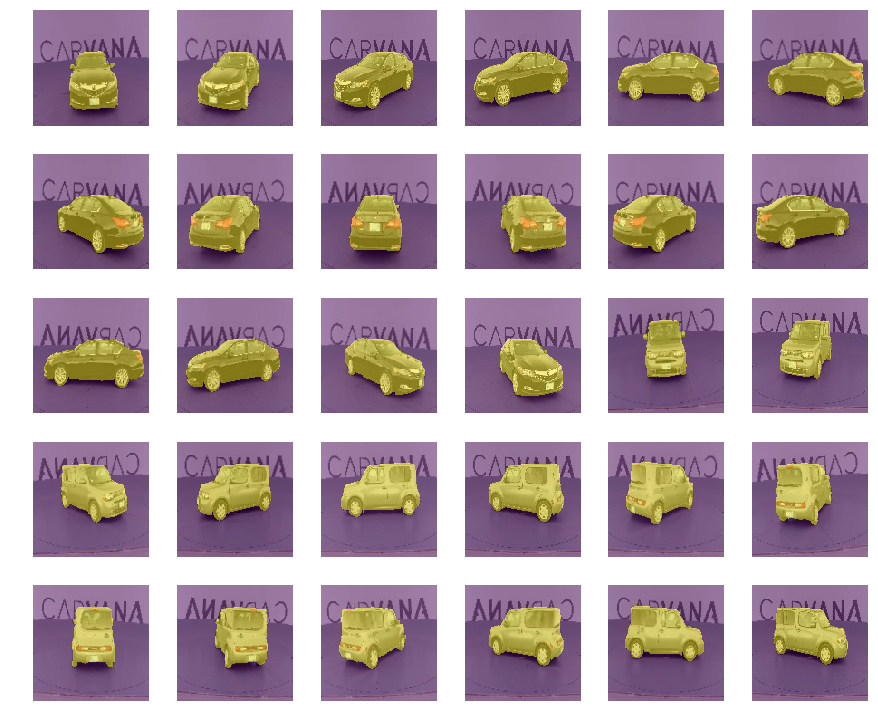

In [93]:
show_cars_mask_dl(md, 5, 6)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 56/64 [00:08<00:01,  6.27it/s, loss=4.25] 


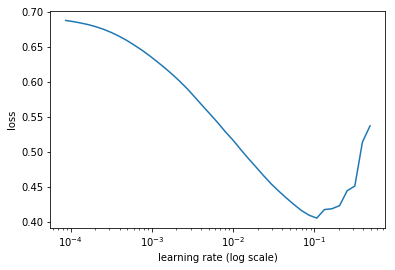

In [94]:
learn.lr_find()
learn.sched.plot()

In [95]:
lr=4e-2

In [96]:
learn.fit(lr,1,cycle_len=5,use_clr=(10,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice           
    0      0.141728   0.114409   0.955733   0.889047  
    1      0.099428   0.085455   0.959824   0.908426        
    2      0.084676   0.085888   0.961108   0.909731        
    3      0.075658   0.075964   0.964811   0.919572        
    4      0.069324   0.072185   0.968153   0.92543         



[0.0721853, 0.96815349534153938, 0.92543046567787202]

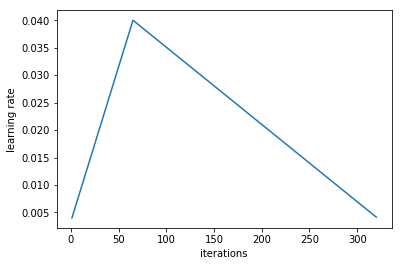

In [97]:
learn.sched.plot_lr()

In [98]:
learn.save('tmp')

In [99]:
learn.load('tmp')

In [100]:
py,ay = learn.predict_with_targs()

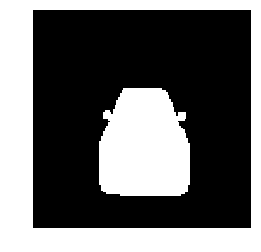

In [101]:
show_img(np.rollaxis(ay[0], 0, 3))

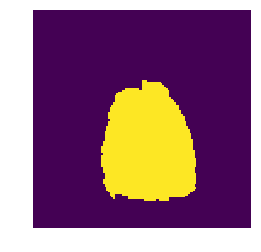

In [102]:
show_img(py[0][0]>0);

In [103]:
learn.unfreeze()

In [104]:
learn.bn_freeze(True)

In [105]:
lrs = np.array([lr/100,lr/10,lr])/4

In [106]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.052409   0.050092   0.977128   0.947558  
    1      0.04349    0.042255   0.982867   0.957561        
    2      0.038185   0.037237   0.9849     0.962322        
    3      0.033518   0.033966   0.984416   0.965504        
    4      0.030004   0.029721   0.987397   0.970475        
    5      0.027221   0.027917   0.988418   0.972436        
    6      0.024947   0.027782   0.988131   0.972588        
    7      0.023345   0.024968   0.989316   0.975383        
    8      0.022334   0.025097   0.989837   0.975455        
    9      0.021217   0.024288   0.990126   0.976359        
    10     0.020512   0.023731   0.989963   0.9769          
    11     0.019859   0.023217   0.990138   0.977379        
    12     0.019539   0.022329   0.990829   0.978341        
    13     0.018918   0.022281   0.990914   0.978572        
    14     0.018391   0.02192    0.990909   0.978984        
    15     0.018136   0.022636

[0.019328538, 0.99268817901611328, 0.98278344542349294]

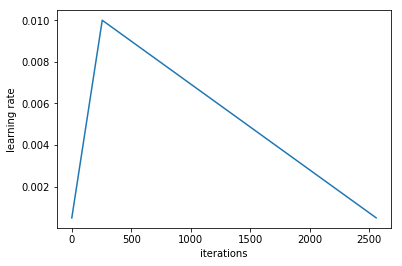

In [107]:
learn.sched.plot_lr()

In [108]:
learn.save('128')

In [109]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [110]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

NameError: name 'denorm' is not defined

In [ ]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [44]:
learn, md = get_model(512, 8, 4, transf)

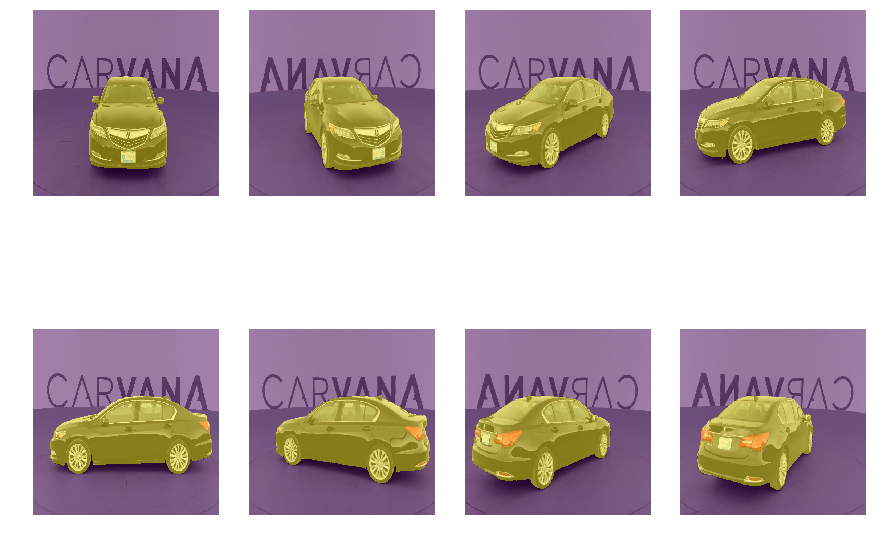

In [112]:
show_cars_mask_dl(md, 2, 4)

In [113]:
learn.load('128')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 205/255 [01:48<00:26,  1.88it/s, loss=0.882] 

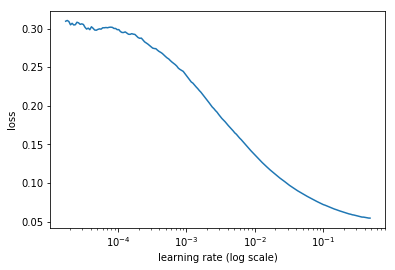

In [114]:
%memit learn.lr_find()
learn.sched.plot()

In [48]:
lr=4e-2

In [116]:
%memit learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 1/255 [00:01<04:53,  1.16s/it, loss=0.331]

Exception in thread Thread-60:
Traceback (most recent call last):
  File "/home/caleb/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/caleb/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/caleb/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc   dice              
    0      0.021163   0.020849   0.991763   0.980819  
    1      0.016806   0.016803   0.992532   0.983718          
    2      0.015385   0.01636    0.993761   0.984626          
    3      0.014589   0.014843   0.993974   0.98595           
    4      0.013498   0.014337   0.993937   0.986331          



[0.014337, 0.99393687929425922, 0.98633106666405812]

In [117]:
learn.save('tmp')

In [45]:
learn.load('tmp')

In [51]:
learn.unfreeze()
learn.bn_freeze(True)

In [52]:
lrs = np.array([lr/100,lr/10,lr])/4

In [53]:
%memit learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice              
    0      0.012517   0.012665   0.994774   0.988188  
    1      0.008737   0.009109   0.996266   0.991619           
    2      0.009791   0.009531   0.996308   0.991386           
    3      0.008066   0.008407   0.996682   0.992264           
    4      0.007416   0.008182   0.996638   0.992582           
    5      0.006924   0.007759   0.996856   0.992939           
    6      0.00671    0.00763    0.997056   0.99316            
    7      0.00651    0.007404   0.9971     0.993363           

peak memory: 28254.04 MiB, increment: 25536.99 MiB


In [54]:
learn.save('512')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [41]:
learn, md = get_model(1024, 3, 0, transf)

In [29]:
learn.load('512')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [33]:
lr=4e-2

In [31]:
%memit learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice               
    0      0.009047   0.009375   0.996414   0.992231  
    1      0.00706    0.007735   0.997147   0.993538           

peak memory: 75073.84 MiB, increment: 72420.21 MiB


In [32]:
learn.save('tmp')

In [34]:
learn.load('tmp')

In [35]:
learn.unfreeze()
learn.bn_freeze(True)

In [36]:
lrs = np.array([lr/100,lr/10,lr])/8

In [37]:
%memit learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice                 
    0      0.005982   0.006386   0.9977     0.994467  
    1      0.004691   0.005711   0.997796   0.995102             
    2      0.004353   0.005471   0.997876   0.995302             
    3      0.004332   0.005259   0.998005   0.99551              

peak memory: 53202.10 MiB, increment: 50549.79 MiB


In [38]:
learn.save('1024')

In [39]:
%memit learn.fit(lrs,1,cycle_len=10,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice                 
    0      0.004937   0.005473   0.997873   0.995058  
    1      0.006767   0.005946   0.997713   0.99491              
    2      0.00427    0.005124   0.998084   0.995521             
    3      0.004055   0.00492    0.998063   0.995628             
    4      0.004242   0.004885   0.998091   0.995619             
    5      0.003914   0.004902   0.998131   0.995781             
    6      0.003769   0.004775   0.998218   0.995789             
    7      0.003741   0.004712   0.998149   0.995852             
    8      0.003711   0.004636   0.998199   0.995936             
    9      0.003459   0.004645   0.998238   0.995999             

peak memory: 53670.21 MiB, increment: 50357.67 MiB


In [40]:
learn.save('1024')

In [42]:
learn.load('1024')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

# Vgg16

In [ ]:
transf = vgg16

## 128x128

In [54]:
learn, md = get_model(128, 64, 8, transf)

In [ ]:
lr=4e-2

In [ ]:
%memit learn.fit(lr,1,cycle_len=5,use_clr=(10,5))

In [ ]:
learn.unfreeze()

In [ ]:
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
%memit learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('128')

## 512x512

In [54]:
learn, md = get_model(512, 16, 4, transf)

In [ ]:
lr=4e-2

In [ ]:
%memit learn.fit(lr,1,cycle_len=5,use_clr=(10,5))

In [ ]:
learn.unfreeze()

In [ ]:
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
%memit learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('128')

## Fin

In [ ]:
x,y = next(iter(md.val_dl))

In [ ]:
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
